<div style="background-color: darkred; padding: 10px; color: white;">

# Training Soma Classifier

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Load Training Data
    
</div>

### Imports

In [1]:
from random import sample

from aind_exaspim_soma_detection.utils import util
from aind_exaspim_soma_detection.training import data_handling
from aind_exaspim_soma_detection.training.data_handling import SomaDataset

%matplotlib inline

### Initializations

In [2]:
# Parameters
anisotropy = [0.748, 0.748, 1.0]
multiscale = 2
patch_shape = (64, 64, 64)

# Paths
img_lookup_path =  "/root/capsule/data/exaspim_image_prefixes.json"
smartsheet_path = "/root/capsule/data/Neuron_Reconstructions.xlsx"
exaspim_soma_path = "/root/capsule/data/exaspim_somas_2024"


### Load Data

In [3]:
# SmartSheet Data
smartsheet_data = data_handling.fetch_smartsheet_somas(
    smartsheet_path,
    img_lookup_path,
    multiscale=multiscale,
)

# ExaSPIM Soma Data
exapsim_data = data_handling.fetch_exaspim_somas_2024(
    exaspim_soma_path,
    img_lookup_path,
    multiscale=multiscale,
)

# Initialize Dataset
soma_dataset = SomaDataset(patch_shape, transform=True)
for example_tuple in smartsheet_data + exapsim_data:
    soma_dataset.ingest_examples(*example_tuple)

print("# Examples:", soma_dataset.n_examples())
print("# Positive Examples", soma_dataset.n_positives())
print("# Negative Examples", soma_dataset.n_negatives())

/opt/conda/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Examples: 2677
# Positive Examples 1884
# Negative Examples 793


### Visualize Training Example

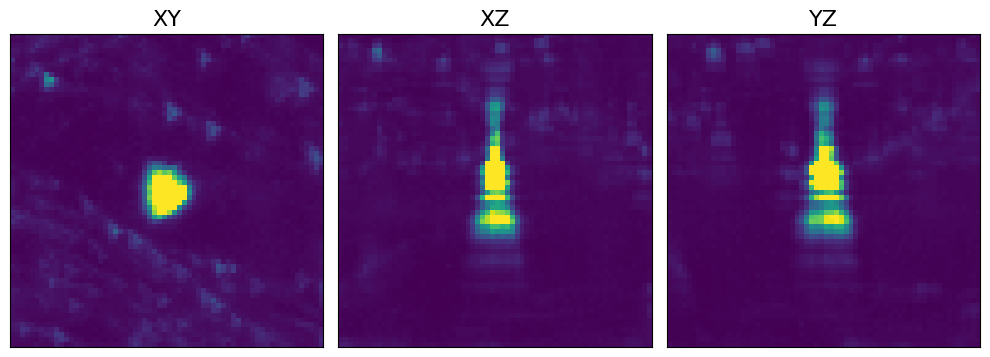

In [4]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_example(key)

### Visualize Augmented Training Example

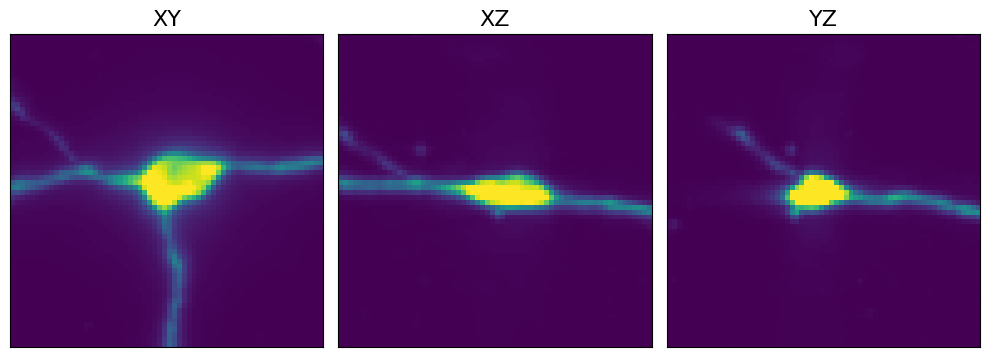

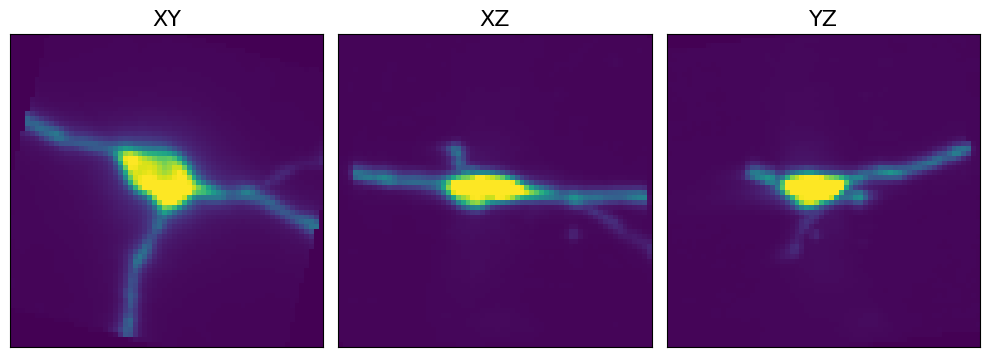

In [5]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_augmented_example(key)

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Train Model
    
</div>

### Imports

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from aind_exaspim_soma_detection.training.data_handling import MultiThreadedDataLoader
from aind_exaspim_soma_detection.training.models import Fast3dCNN

### Subroutines

In [7]:
def partition(super_list, sub_list):
    return list(filter(lambda x: x not in sub_list, super_list))


def split_train_validation(examples, train_ratio):
    # Get numbers of examples
    n_train_examples = int(train_ratio * len(examples))
    n_valid_examples = len(examples) - n_train_examples

    # Sample keys
    train_keys = sample(examples.keys(), n_train_examples)
    valid_keys = partition(examples.keys(), train_keys)

    # Get examples
    train_examples = dict({k: examples[k] for k in train_keys})
    valid_examples = dict({k: examples[k] for k in valid_keys})
    return train_examples, valid_examples


def merge_examples(soma_dataset, positives, negatives):
    examples = list()
    combined_dict = positives.copy()
    combined_dict.update(negatives)
    for key, value in combined_dict.items():
        brain_id, voxel = key
        img_path = soma_dataset.img_paths[brain_id]
        examples.append((brain_id, img_path, [voxel], [value]))
    return examples


def init_subdataset(dataset, positives, negatives, patch_shape, transform):
    subdataset = SomaDataset(patch_shape, transform=transform)
    for example_tuple in merge_examples(dataset, positives, negatives):
        subdataset.ingest_examples(*example_tuple)
    return subdataset


def evaluation_metrics(epoch, y, hat_y, prefix=""):
    # Compute metrics
    accuracy = accuracy_score(y, hat_y)
    accuracy_dif = accuracy - np.sum(y) / len(y)
    f1 = f1_score(y, hat_y)
    precision = precision_score(y, hat_y)
    recall = recall_score(y, hat_y)

    # Write results to tensorboard
    writer.add_scalar(prefix + "_accuracy", accuracy, epoch)
    writer.add_scalar(prefix + "_accuracy_df", accuracy_dif, epoch)
    writer.add_scalar(prefix + "_precision:", precision, epoch)
    writer.add_scalar(prefix + "_recall:", recall, epoch)
    writer.add_scalar(prefix + "_f1:", f1, epoch)

    # Print results   ~ temp
    print("Evalation Metrics -", prefix)
    print("Accuracy:", accuracy)
    print("Accuracy Dif:", accuracy_dif)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)


### Initialize Datasets

In [8]:
# Parameters
transform = True
train_ratio = 0.85

# Train-Validation Split - Negative examples
train_negatives, valid_negatives = split_train_validation(
    soma_dataset.get_negatives(), train_ratio
)

# Train-Validation Split - Positive examples
n_negatives = len(train_negatives) + len(valid_negatives)
positives_keys = sample(soma_dataset.get_positives().keys(), n_negatives)
positive_examples = dict({k: soma_dataset.examples[k] for k in positives_keys})
train_positives, valid_positives = split_train_validation(
    positive_examples, train_ratio
)

# Train-Validation Datasets
train_soma_dataset = init_subdataset(
    soma_dataset, train_positives, train_negatives, patch_shape, True
)
valid_soma_dataset = init_subdataset(
    soma_dataset, valid_positives, valid_negatives, patch_shape, False
)

### Training Loop

In [10]:
# Parameters
batch_size = 32
lr = 1e-4
lr_gamma = 0.8
lr_step_size = 20
n_epochs = 100

# Initializations
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Fast3dCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
writer = SummaryWriter()

train_dataloader = MultiThreadedDataLoader(train_soma_dataset, batch_size)
valid_dataloader = MultiThreadedDataLoader(valid_soma_dataset, batch_size)
train_total = len(train_soma_dataset) // batch_size
valid_total = len(valid_soma_dataset) // batch_size

# updates 
# -- try adamw
# -- change scheduler to cosine schedule
# -- also look into schedule free work from neurips

# Main
model.to(device)
n_updates = 0
for epoch in range(n_epochs):
    # Train model
    print(f"Epoch {epoch}:")
    model.train()
    y, hat_y = list(), list()
    for i, (x_i, y_i) in tqdm(enumerate(train_dataloader), total=train_total):
        # Forward pass
        x_i, y_i = x_i.to(device), y_i.to(device)
        hat_y_i = model(x_i)
        loss = criterion(hat_y_i, y_i)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss, n_updates)
        n_updates += 1

        # Store prediction
        y.append(np.array(y_i.detach().cpu()))
        hat_y.append(np.array(hat_y_i.detach().cpu()))

    # Compute performance metrics
    y = np.vstack(y)
    hat_y = (np.vstack(hat_y) > 0).astype(int)
    evaluation_metrics(epoch, y, hat_y, prefix="train")

    # Validate model
    model.eval()
    y, hat_y = list(), list()
    for i, (x_i, y_i) in tqdm(enumerate(valid_dataloader), total=valid_total):
        # Forward pass
        x_i = x_i.to(device)
        hat_y_i = model(x_i)

        y.append(np.array(y_i))
        hat_y.append(np.array(hat_y_i.detach().cpu()))

    # Compute performance metrics
    y = np.vstack(y)
    hat_y = (np.vstack(hat_y) > 0).astype(int)
    evaluation_metrics(epoch, y, hat_y, prefix="valid")

    # Step the scheduler
    #scheduler.step()

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0:


43it [02:25,  3.39s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.6632047477744807
Accuracy Dif: 0.16320474777448069
F1: 0.6308943089430894
Precision: 0.697841726618705
Recall: 0.5756676557863502


8it [00:19,  2.47s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.5294117647058824
Accuracy Dif: 0.02941176470588236
F1: 0.1111111111111111
Precision: 1.0
Recall: 0.058823529411764705
Epoch 1:


43it [02:23,  3.33s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.7040059347181009
Accuracy Dif: 0.2040059347181009
F1: 0.6721446179129006
Precision: 0.7532228360957642
Recall: 0.6068249258160238


8it [00:19,  2.50s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6890756302521008
Accuracy Dif: 0.18907563025210083
F1: 0.5697674418604651
Precision: 0.9245283018867925
Recall: 0.4117647058823529
Epoch 2:


43it [02:10,  3.04s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.7655786350148368
Accuracy Dif: 0.2655786350148368
F1: 0.7303754266211605
Precision: 0.8594377510040161
Recall: 0.6350148367952523


8it [00:18,  2.34s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7058823529411765
Accuracy Dif: 0.20588235294117652
F1: 0.5977011494252873
Precision: 0.9454545454545454
Recall: 0.4369747899159664
Epoch 3:


43it [01:56,  2.71s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.7722551928783383
Accuracy Dif: 0.2722551928783383
F1: 0.7396098388464801
Precision: 0.8633663366336634
Recall: 0.6468842729970327


8it [00:14,  1.75s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8151260504201681
Accuracy Dif: 0.31512605042016806
F1: 0.794392523364486
Precision: 0.8947368421052632
Recall: 0.7142857142857143
Epoch 4:


43it [01:48,  2.51s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.7967359050445104
Accuracy Dif: 0.2967359050445104
F1: 0.7697478991596639
Precision: 0.8875968992248062
Recall: 0.6795252225519288


8it [00:12,  1.50s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6722689075630253
Accuracy Dif: 0.17226890756302526
F1: 0.5125
Precision: 1.0
Recall: 0.3445378151260504
Epoch 5:


43it [01:41,  2.35s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8026706231454006
Accuracy Dif: 0.3026706231454006
F1: 0.7783333333333332
Precision: 0.8878326996197718
Recall: 0.6928783382789317


8it [00:13,  1.64s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.5672268907563025
Accuracy Dif: 0.0672268907563025
F1: 0.6961651917404129
Precision: 0.5363636363636364
Recall: 0.9915966386554622
Epoch 6:


43it [01:41,  2.35s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8100890207715133
Accuracy Dif: 0.31008902077151335
F1: 0.7911908646003263
Precision: 0.8786231884057971
Recall: 0.7195845697329377


8it [00:12,  1.54s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7226890756302521
Accuracy Dif: 0.2226890756302521
F1: 0.625
Precision: 0.9649122807017544
Recall: 0.46218487394957986
Epoch 7:


43it [01:35,  2.23s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8160237388724035
Accuracy Dif: 0.31602373887240354
F1: 0.7926421404682273
Precision: 0.9080459770114943
Recall: 0.7032640949554896


8it [00:11,  1.44s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8277310924369747
Accuracy Dif: 0.32773109243697474
F1: 0.8127853881278538
Precision: 0.89
Recall: 0.7478991596638656
Epoch 8:


43it [01:38,  2.29s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8286350148367952
Accuracy Dif: 0.32863501483679525
F1: 0.8147554129911788
Precision: 0.8865619546247818
Recall: 0.7537091988130564


8it [00:11,  1.46s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.773109243697479
Accuracy Dif: 0.273109243697479
F1: 0.7300000000000001
Precision: 0.9012345679012346
Recall: 0.6134453781512605
Epoch 9:


43it [01:37,  2.26s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8375370919881305
Accuracy Dif: 0.33753709198813053
F1: 0.8240963855421687
Precision: 0.8984238178633975
Recall: 0.7611275964391692


8it [00:11,  1.43s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6848739495798319
Accuracy Dif: 0.18487394957983194
F1: 0.7588424437299035
Precision: 0.6145833333333334
Recall: 0.9915966386554622
Epoch 10:


43it [01:36,  2.26s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8382789317507419
Accuracy Dif: 0.33827893175074186
F1: 0.8258785942492013
Precision: 0.8944636678200693
Recall: 0.7670623145400594


8it [00:11,  1.47s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7521008403361344
Accuracy Dif: 0.25210084033613445
F1: 0.6844919786096255
Precision: 0.9411764705882353
Recall: 0.5378151260504201
Epoch 11:


43it [01:35,  2.23s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.849406528189911
Accuracy Dif: 0.349406528189911
F1: 0.8374699759807847
Precision: 0.9095652173913044
Recall: 0.7759643916913946


8it [00:11,  1.47s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7647058823529411
Accuracy Dif: 0.2647058823529411
F1: 0.6989247311827957
Precision: 0.9701492537313433
Recall: 0.5462184873949579
Epoch 12:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8479228486646885
Accuracy Dif: 0.3479228486646885
F1: 0.8331977217249797
Precision: 0.9225225225225225
Recall: 0.7596439169139466


8it [00:11,  1.41s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8403361344537815
Accuracy Dif: 0.3403361344537815
F1: 0.822429906542056
Precision: 0.9263157894736842
Recall: 0.7394957983193278
Epoch 13:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.844213649851632
Accuracy Dif: 0.34421364985163205
F1: 0.832
Precision: 0.9027777777777778
Recall: 0.771513353115727


8it [00:11,  1.38s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6554621848739496
Accuracy Dif: 0.15546218487394958
F1: 0.7421383647798743
Precision: 0.592964824120603
Recall: 0.9915966386554622
Epoch 14:


43it [01:34,  2.21s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8479228486646885
Accuracy Dif: 0.3479228486646885
F1: 0.8404669260700389
Precision: 0.88379705400982
Recall: 0.8011869436201781


8it [00:11,  1.46s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6974789915966386
Accuracy Dif: 0.19747899159663862
F1: 0.767741935483871
Precision: 0.6230366492146597
Recall: 1.0
Epoch 15:


43it [01:35,  2.23s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8583086053412463
Accuracy Dif: 0.3583086053412463
F1: 0.8543096872616324
Precision: 0.8791208791208791
Recall: 0.8308605341246291


8it [00:11,  1.47s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.5462184873949579
Accuracy Dif: 0.04621848739495793
F1: 0.6878612716763006
Precision: 0.5242290748898678
Recall: 1.0
Epoch 16:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8316023738872403
Accuracy Dif: 0.33160237388724034
F1: 0.8182546036829463
Precision: 0.888695652173913
Recall: 0.7581602373887241


8it [00:11,  1.40s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6176470588235294
Accuracy Dif: 0.11764705882352944
F1: 0.7234042553191489
Precision: 0.5666666666666667
Recall: 1.0
Epoch 17:


43it [01:35,  2.21s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8672106824925816
Accuracy Dif: 0.3672106824925816
F1: 0.8611326609775019
Precision: 0.9024390243902439
Recall: 0.8234421364985163


8it [00:11,  1.42s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8235294117647058
Accuracy Dif: 0.32352941176470584
F1: 0.832
Precision: 0.7938931297709924
Recall: 0.8739495798319328
Epoch 18:


43it [01:35,  2.22s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.884272997032641
Accuracy Dif: 0.38427299703264095
F1: 0.8819969742813918
Precision: 0.8996913580246914
Recall: 0.8649851632047477


8it [00:11,  1.39s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.773109243697479
Accuracy Dif: 0.273109243697479
F1: 0.8111888111888111
Precision: 0.6946107784431138
Recall: 0.9747899159663865
Epoch 19:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8976261127596439
Accuracy Dif: 0.3976261127596439
F1: 0.8957703927492446
Precision: 0.9123076923076923
Recall: 0.8798219584569733


8it [00:11,  1.39s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8445378151260504
Accuracy Dif: 0.3445378151260504
F1: 0.8593155893536122
Precision: 0.7847222222222222
Recall: 0.9495798319327731
Epoch 20:


43it [01:34,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.887240356083086
Accuracy Dif: 0.38724035608308605
F1: 0.8850226928895613
Precision: 0.9027777777777778
Recall: 0.8679525222551929


8it [00:11,  1.41s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8487394957983193
Accuracy Dif: 0.3487394957983193
F1: 0.8285714285714286
Precision: 0.9560439560439561
Recall: 0.7310924369747899
Epoch 21:


43it [01:33,  2.17s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8850148367952523
Accuracy Dif: 0.3850148367952523
F1: 0.8830188679245283
Precision: 0.8986175115207373
Recall: 0.8679525222551929


8it [00:11,  1.41s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.819327731092437
Accuracy Dif: 0.31932773109243695
F1: 0.8413284132841328
Precision: 0.75
Recall: 0.957983193277311
Epoch 22:


43it [01:33,  2.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8864985163204748
Accuracy Dif: 0.3864985163204748
F1: 0.8834729626808835
Precision: 0.9076682316118936
Recall: 0.8605341246290801


8it [00:11,  1.40s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7352941176470589
Accuracy Dif: 0.23529411764705888
F1: 0.7892976588628763
Precision: 0.6555555555555556
Recall: 0.9915966386554622
Epoch 23:


43it [01:33,  2.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8605341246290801
Accuracy Dif: 0.3605341246290801
F1: 0.8607407407407406
Precision: 0.8594674556213018
Recall: 0.8620178041543026


8it [00:10,  1.37s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8025210084033614
Accuracy Dif: 0.3025210084033614
F1: 0.7614213197969542
Precision: 0.9615384615384616
Recall: 0.6302521008403361
Epoch 24:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8753709198813057
Accuracy Dif: 0.37537091988130566
F1: 0.8713629402756508
Precision: 0.9003164556962026
Recall: 0.844213649851632


8it [00:11,  1.43s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7815126050420168
Accuracy Dif: 0.2815126050420168
F1: 0.7291666666666667
Precision: 0.958904109589041
Recall: 0.5882352941176471
Epoch 25:


43it [01:32,  2.16s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8857566765578635
Accuracy Dif: 0.3857566765578635
F1: 0.8838612368024134
Precision: 0.8987730061349694
Recall: 0.8694362017804155


8it [00:11,  1.38s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8319327731092437
Accuracy Dif: 0.33193277310924374
F1: 0.8507462686567164
Precision: 0.7651006711409396
Recall: 0.957983193277311
Epoch 26:


43it [01:32,  2.16s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9043026706231454
Accuracy Dif: 0.4043026706231454
F1: 0.9017517136329017
Precision: 0.9264475743348983
Recall: 0.8783382789317508


8it [00:11,  1.38s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8823529411764706
Accuracy Dif: 0.38235294117647056
F1: 0.8793103448275862
Precision: 0.9026548672566371
Recall: 0.8571428571428571
Epoch 27:


43it [01:32,  2.15s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9117210682492581
Accuracy Dif: 0.41172106824925814
F1: 0.9109947643979056
Precision: 0.918552036199095
Recall: 0.9035608308605341


8it [00:11,  1.41s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8487394957983193
Accuracy Dif: 0.3487394957983193
F1: 0.8378378378378379
Precision: 0.9029126213592233
Recall: 0.7815126050420168
Epoch 28:


43it [01:33,  2.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9109792284866469
Accuracy Dif: 0.4109792284866469
F1: 0.908256880733945
Precision: 0.9369085173501577
Recall: 0.8813056379821959


8it [00:10,  1.36s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.592436974789916
Accuracy Dif: 0.09243697478991597
F1: 0.7104477611940299
Precision: 0.5509259259259259
Recall: 1.0
Epoch 29:


43it [01:34,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.908753709198813
Accuracy Dif: 0.40875370919881304
F1: 0.9075882794891059
Precision: 0.9193302891933028
Recall: 0.8961424332344213


8it [00:10,  1.32s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8781512605042017
Accuracy Dif: 0.37815126050420167
F1: 0.88715953307393
Precision: 0.8260869565217391
Recall: 0.957983193277311
Epoch 30:


43it [01:31,  2.13s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9124629080118695
Accuracy Dif: 0.41246290801186947
F1: 0.9118086696562033
Precision: 0.9186746987951807
Recall: 0.9050445103857567


8it [00:11,  1.43s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8277310924369747
Accuracy Dif: 0.32773109243697474
F1: 0.7960199004975125
Precision: 0.975609756097561
Recall: 0.6722689075630253
Epoch 31:


43it [01:32,  2.15s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9154302670623146
Accuracy Dif: 0.41543026706231456
F1: 0.9156804733727811
Precision: 0.9129793510324484
Recall: 0.9183976261127597


8it [00:11,  1.44s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8781512605042017
Accuracy Dif: 0.37815126050420167
F1: 0.8835341365461847
Precision: 0.8461538461538461
Recall: 0.9243697478991597
Epoch 32:


43it [01:35,  2.21s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9124629080118695
Accuracy Dif: 0.41246290801186947
F1: 0.9107413010590015
Precision: 0.9290123456790124
Recall: 0.8931750741839762


8it [00:11,  1.39s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8235294117647058
Accuracy Dif: 0.32352941176470584
F1: 0.8478260869565217
Precision: 0.7452229299363057
Recall: 0.9831932773109243
Epoch 33:


43it [01:34,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9235905044510386
Accuracy Dif: 0.42359050445103863
F1: 0.9227306826706677
Precision: 0.9332321699544764
Recall: 0.9124629080118695


8it [00:10,  1.36s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8025210084033614
Accuracy Dif: 0.3025210084033614
F1: 0.8327402135231317
Precision: 0.7222222222222222
Recall: 0.9831932773109243
Epoch 34:


43it [01:34,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9272997032640949
Accuracy Dif: 0.42729970326409494
F1: 0.926865671641791
Precision: 0.9324324324324325
Recall: 0.9213649851632048


8it [00:11,  1.44s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8067226890756303
Accuracy Dif: 0.3067226890756303
F1: 0.8368794326241135
Precision: 0.7239263803680982
Recall: 0.9915966386554622
Epoch 35:


43it [01:33,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9280415430267063
Accuracy Dif: 0.4280415430267063
F1: 0.928728875826598
Precision: 0.9199417758369723
Recall: 0.9376854599406528


8it [00:11,  1.40s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6722689075630253
Accuracy Dif: 0.17226890756302526
F1: 0.7531645569620254
Precision: 0.6040609137055838
Recall: 1.0
Epoch 36:


43it [01:35,  2.21s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9362017804154302
Accuracy Dif: 0.43620178041543023
F1: 0.9352409638554217
Precision: 0.9495412844036697
Recall: 0.9213649851632048


8it [00:11,  1.44s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8907563025210085
Accuracy Dif: 0.39075630252100846
F1: 0.8916666666666667
Precision: 0.8842975206611571
Recall: 0.8991596638655462
Epoch 37:


43it [01:36,  2.24s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.935459940652819
Accuracy Dif: 0.435459940652819
F1: 0.9357933579335794
Precision: 0.9309838472834068
Recall: 0.9406528189910979


8it [00:11,  1.38s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8151260504201681
Accuracy Dif: 0.31512605042016806
F1: 0.8394160583941607
Precision: 0.7419354838709677
Recall: 0.9663865546218487
Epoch 38:


43it [01:35,  2.22s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9399109792284867
Accuracy Dif: 0.43991097922848665
F1: 0.9399555226093402
Precision: 0.9392592592592592
Recall: 0.9406528189910979


8it [00:11,  1.44s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8403361344537815
Accuracy Dif: 0.3403361344537815
F1: 0.8118811881188117
Precision: 0.9879518072289156
Recall: 0.6890756302521008
Epoch 39:


43it [01:34,  2.21s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9324925816023739
Accuracy Dif: 0.4324925816023739
F1: 0.9319371727748691
Precision: 0.9396681749622926
Recall: 0.9243323442136498


8it [00:10,  1.37s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7521008403361344
Accuracy Dif: 0.25210084033613445
F1: 0.8013468013468014
Precision: 0.6685393258426966
Recall: 1.0
Epoch 40:


43it [01:34,  2.20s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9473293768545994
Accuracy Dif: 0.4473293768545994
F1: 0.946576373212942
Precision: 0.9603053435114504
Recall: 0.9332344213649851


8it [00:12,  1.50s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.7436974789915967
Accuracy Dif: 0.24369747899159666
F1: 0.7959866220735786
Precision: 0.6611111111111111
Recall: 1.0
Epoch 41:


43it [01:33,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9510385756676558
Accuracy Dif: 0.4510385756676558
F1: 0.9508196721311475
Precision: 0.9550898203592815
Recall: 0.9465875370919882


8it [00:11,  1.40s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6848739495798319
Accuracy Dif: 0.18487394957983194
F1: 0.5398773006134969
Precision: 1.0
Recall: 0.3697478991596639
Epoch 42:


43it [01:34,  2.19s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9028189910979229
Accuracy Dif: 0.40281899109792285
F1: 0.9023117076808352
Precision: 0.9070464767616192
Recall: 0.8976261127596439


8it [00:10,  1.36s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8403361344537815
Accuracy Dif: 0.3403361344537815
F1: 0.822429906542056
Precision: 0.9263157894736842
Recall: 0.7394957983193278
Epoch 43:


43it [01:33,  2.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.8827893175074184
Accuracy Dif: 0.3827893175074184
F1: 0.881203007518797
Precision: 0.8932926829268293
Recall: 0.8694362017804155


8it [00:11,  1.41s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.6302521008403361
Accuracy Dif: 0.13025210084033612
F1: 0.7300613496932515
Precision: 0.5748792270531401
Recall: 1.0
Epoch 44:


43it [01:33,  2.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9124629080118695
Accuracy Dif: 0.41246290801186947
F1: 0.9116766467065868
Precision: 0.9199395770392749
Recall: 0.9035608308605341


8it [00:11,  1.39s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8739495798319328
Accuracy Dif: 0.3739495798319328
F1: 0.8846153846153846
Precision: 0.8156028368794326
Recall: 0.9663865546218487
Epoch 45:


43it [01:32,  2.16s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9250741839762612
Accuracy Dif: 0.4250741839762612
F1: 0.924907063197026
Precision: 0.9269746646795827
Recall: 0.9228486646884273


8it [00:10,  1.31s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8613445378151261
Accuracy Dif: 0.3613445378151261
F1: 0.8725868725868726
Precision: 0.8071428571428572
Recall: 0.9495798319327731
Epoch 46:


43it [01:33,  2.17s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9413946587537092
Accuracy Dif: 0.4413946587537092
F1: 0.941263940520446
Precision: 0.9433681073025335
Recall: 0.9391691394658753


8it [00:10,  1.34s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.819327731092437
Accuracy Dif: 0.31932773109243695
F1: 0.8458781362007168
Precision: 0.7375
Recall: 0.9915966386554622
Epoch 47:


43it [01:35,  2.23s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9465875370919882
Accuracy Dif: 0.4465875370919882
F1: 0.9467455621301776
Precision: 0.943952802359882
Recall: 0.9495548961424333


8it [00:11,  1.38s/it]                       
  0%|          | 0/42 [00:00<?, ?it/s]

Evalation Metrics - valid
Accuracy: 0.8403361344537815
Accuracy Dif: 0.3403361344537815
F1: 0.8592592592592593
Precision: 0.7682119205298014
Recall: 0.9747899159663865
Epoch 48:


43it [01:31,  2.13s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Evalation Metrics - train
Accuracy: 0.9451038575667656
Accuracy Dif: 0.4451038575667656
F1: 0.9451851851851854
Precision: 0.9437869822485208
Recall: 0.9465875370919882


 71%|███████▏  | 5/7 [00:07<00:03,  1.57s/it]

KeyboardInterrupt

